The goal of this notebook is to create a model capable to tell if a patient is having a epileptic seizure based on data from an EEG. 
Source of the data: https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

In [1]:
#Computation
import numpy as np
from scipy.interpolate import interp1d
#Loading data
from pandas import read_csv
#Plotting
import matplotlib.pyplot as plt
from seaborn import set_style
#Machine Learning
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import CuDNNGRU, CuDNNLSTM, Dropout, MaxPooling1D, Dense, Conv1D
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data = read_csv('./data.csv')
data.head(10)

The provided data has already been cleaned so all that needs to be done is prepare the data for training. The first step is getting rid of the first column.

In [3]:
data.drop("Unnamed: 0", inplace=True, axis=1)
data = np.array(data)

Before doing anything else I decided to have a look at the data from a sample of every class.

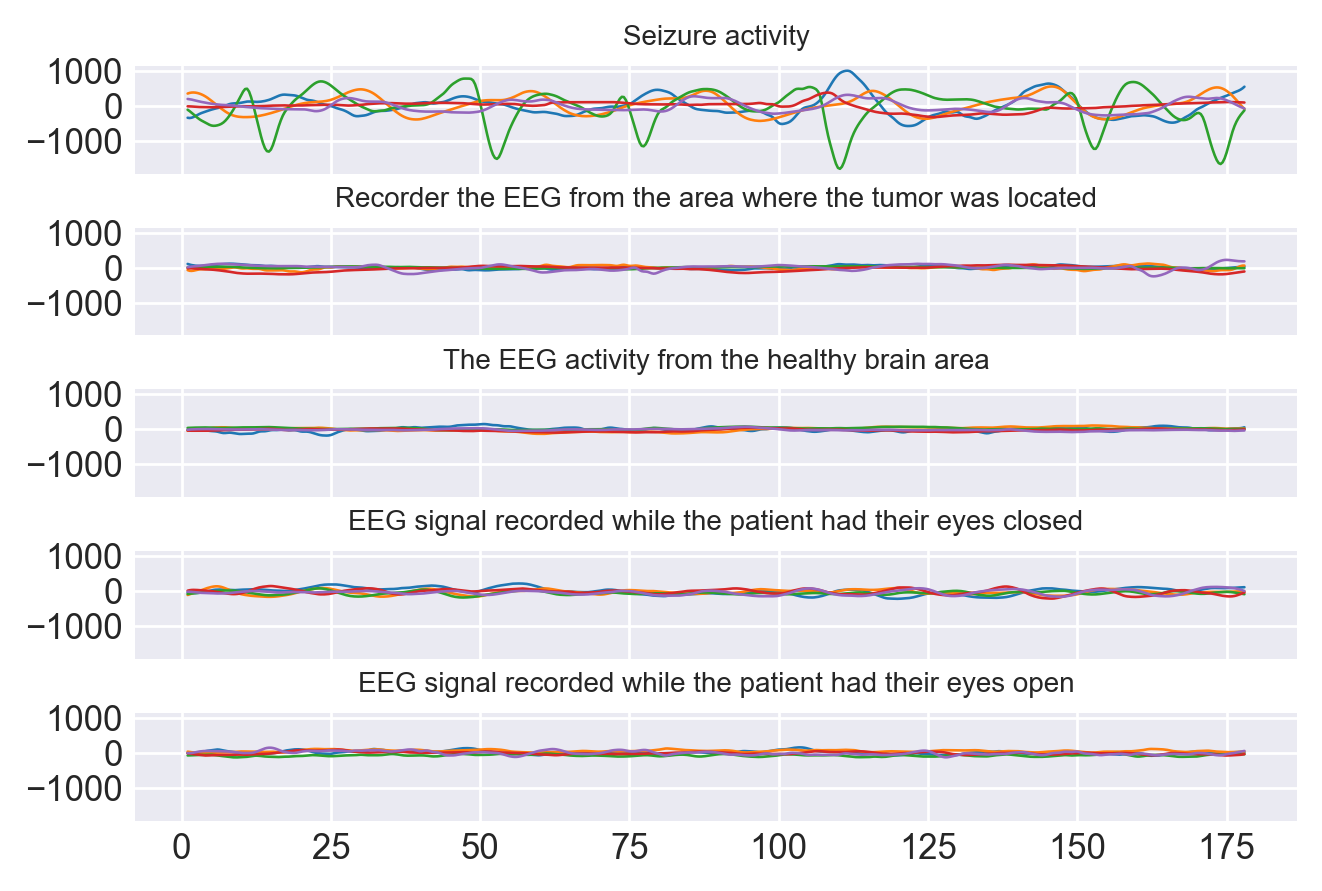

In [4]:
title = (
    "Seizure activity",
    "Recorder the EEG from the area where the tumor was located",
    "The EEG activity from the healthy brain area",
    "EEG signal recorded while the patient had their eyes closed",
    "EEG signal recorded while the patient had their eyes open"
)
index = np.random.randint(10000) #choose a random point from where to plot the data
classes = 5 #defines how many subplots will be created
per_plot = 5 #defines how many observations from every class will be plot
plots = classes * per_plot 
check = np.zeros((classes, 1))
fig, axarr = plt.subplots(classes, sharex=True, sharey=True, dpi=250) #create the plot
set_style('darkgrid') #set a style for plotting
x = np.linspace(1,178,178) #Create a array to represent the flow of time
x_new = np.linspace(1,178,178 * 3) #same purpose as above but more points
while(plots>0):
    case = data[index, 178] - 1
    if(check[case] < per_plot):
        interp = interp1d(x,data[index,:-1], 'cubic') #perform interpolation to make a smooth plot
        axarr[case].plot(x_new, interp(x_new), linewidth=0.75) #plot the sample
        check[case,0] += 1
        plots -= 1
    index += 1
for i in np.arange(classes):
    axarr[i].set_title(title[i], fontsize=8) #give every subplot a title
fig.subplots_adjust(hspace=0.5) #adjust the placement of the subplots
plt.show()

Taking a look at the plot it is very obvious that seizure activity can be easily identified with the naked eye so it is to be expected that a good model should reach very high accuracy.

The next step is to prepare the data for training and validation.

In [5]:
X_set, Y_set = np.hsplit(data, [178]) #split the data into the variables and predeiction
Y_set[Y_set > 1] = 0 #set all non-seizure classes to be 1 class
X_set = X_set.astype('float32') #set the correct data type
X_train, X_test, Y_train, Y_test = train_test_split(X_set, Y_set, test_size=0.2) #split the data
min_scale = np.min(X_train)
max_scale = np.max(X_train) - min_scale
X_train, X_test = (X_train - min_scale)/max_scale, (X_test - min_scale)/max_scale #rescale data
X_train = X_train.reshape(9200, 178, 1) 
X_test = X_test.reshape(2300, 178, 1)

The first was seprating the class labels from the data used to predict them. Once that was done I've set all all classes that had no seizure activity to be a single class, and set the correct data type for the input varaibles. Finaly I've divded the data into training and validation set
with a 4:1 ratio, rescalled them to fit between 0 and 1 and reshaped them.

In [6]:
def plot_results(hist, name):
    fig, ax = plt.subplots(1,2) 
    epochs = np.max(history.epoch) + 1
    x = np.arange(epochs)
    #plot accuracy
    ax[0].plot(x, history.history['acc'], c='cyan', label='Training')
    ax[0].plot(x, history.history['val_acc'], c='purple', label='Validation')
    ax[0].set_title('Accuracy')
    #plot loss
    ax[1].plot(x, history.history['loss'], c='cyan', label='Training')
    ax[1].plot(x, history.history['val_loss'], c='purple', label='Validation')
    ax[1].set_title('Loss')
    plt.legend()
    plt.show()
    #print out additional information on the screen
    print(name,
          "\nFinal training loss:", history.history['loss'][epochs - 1],
          "\nBest training loss:", np.max(history.history['loss']),
          "\nFinal validation loss:", history.history['val_loss'][epochs - 1],
          "\nBest validation loss:", np.max(history.history['val_loss']),
          "\nFinal training accuracy:", history.history['acc'][epochs - 1],
          "\nBest training accuracy:", np.max(history.history['acc']),
          "\nFinal validation accuracy:", history.history['val_acc'][epochs - 1],
          "\nBest validation accuracy:", np.max(history.history['val_acc']))

Before starting to search for a good model I've created a function that plots uses the history returned by keras in order to plot accuracy and loss for both training and validation during learning.

The first model consisted from only 1 GRU layer and a output.
The second model consisted from only 1 LSTM layer and a output.
These models were created in order to find out which one is a better fit presented problem.

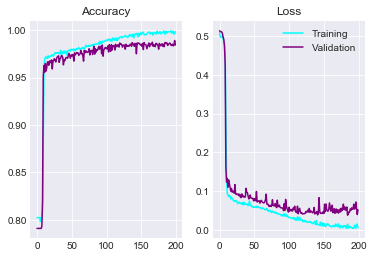

GRU 
Final training loss: 0.00547109830021 
Best training loss: 0.50860574064 
Final validation loss: 0.0516808842552 
Best validation loss: 0.513986504233 
Final training accuracy: 0.998695652174 
Best training accuracy: 0.999456521739 
Final validation accuracy: 0.984347826087 
Best validation accuracy: 0.989130434783


In [7]:
model_1 = Sequential()
model_1.add(CuDNNGRU(100, input_shape=(178, 1)))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'GRU')

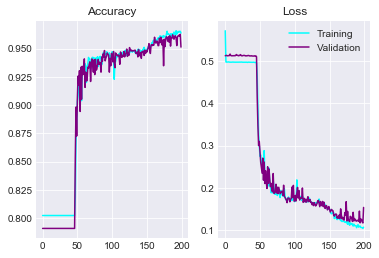

LSTM 
Final training loss: 0.107100116338 
Best training loss: 0.571496778571 
Final validation loss: 0.153784094064 
Best validation loss: 0.516286491726 
Final training accuracy: 0.963695652278 
Best training accuracy: 0.965760869565 
Final validation accuracy: 0.951304347826 
Best validation accuracy: 0.962608695652


In [8]:
model_1 = Sequential()
model_1.add(CuDNNLSTM(50, input_shape=(178, 1)))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer=Adam(lr=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'LSTM')

Both models seem to be doing quite good but GRU achieve a much better result than LSTM, the curve is smoother and the achieved accuracy is a quite a bit better. 

The next involves using a additional hidden layer after the recurrent layer.

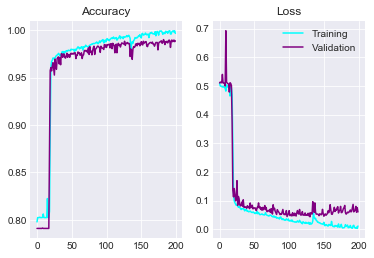

Deep GRU 
Final training loss: 0.011370126348 
Best training loss: 0.508796061899 
Final validation loss: 0.0604224994289 
Best validation loss: 0.692435578989 
Final training accuracy: 0.99652173913 
Best training accuracy: 0.999347826087 
Final validation accuracy: 0.988695652174 
Best validation accuracy: 0.99


In [9]:
model_1 = Sequential()
model_1.add(CuDNNGRU(100, input_shape=(178, 1)))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'Deep GRU')

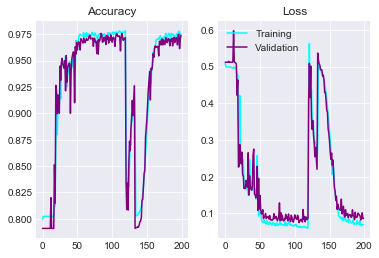

Deep LSTM 
Final training loss: 0.0704461778101 
Best training loss: 0.562408935816 
Final validation loss: 0.0864151428834 
Best validation loss: 0.597361380432 
Final training accuracy: 0.974565217288 
Best training accuracy: 0.978260869462 
Final validation accuracy: 0.973913043478 
Best validation accuracy: 0.975652173913


In [10]:
model_1 = Sequential()
model_1.add(CuDNNLSTM(40, input_shape=(178, 1)))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'Deep LSTM')

Once again the GRU network outperforms the LSTM one achieving a 99% accuracy at it's best, while LSTM only manages to achieve 97,39%. Not only that but the LSTM network also seems to be prone to finding very bad local optima.

The last network involves using a CONV layer before feeding the data into the recurrent layer.

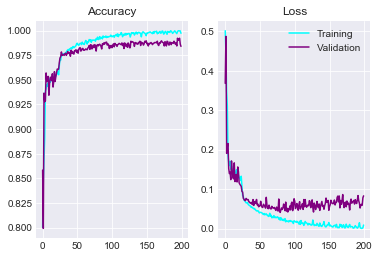

Deep CONV GRU 
Final training loss: 0.00911194175059 
Best training loss: 0.501088528374 
Final validation loss: 0.0830410239252 
Best validation loss: 0.486900817259 
Final training accuracy: 0.997173913043 
Best training accuracy: 0.999782608696 
Final validation accuracy: 0.983913043478 
Best validation accuracy: 0.992173913043


In [11]:
model_1 = Sequential()
model_1.add(Conv1D(filters=128, kernel_size=3, input_shape=(178,1), activation='relu'))
model_1.add(MaxPooling1D(4))
model_1.add(CuDNNGRU(100))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'Deep CONV GRU')

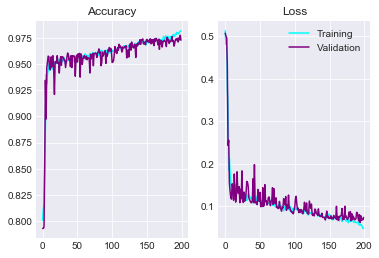

Deep CONV LSTM 
Final training loss: 0.0482350819817 
Best training loss: 0.512961201305 
Final validation loss: 0.0737633893088 
Best validation loss: 0.507187884217 
Final training accuracy: 0.981630434886 
Best training accuracy: 0.981630434886 
Final validation accuracy: 0.972608694927 
Best validation accuracy: 0.977391304348


In [12]:
model_1 = Sequential()
model_1.add(Conv1D(filters=128, kernel_size=3, input_shape=(178,1), activation='relu'))
model_1.add(MaxPooling1D(4))
model_1.add(CuDNNLSTM(40))
model_1.add(Dropout(0.2))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model_1.fit(X_train, Y_train,
                      batch_size=64,
                      epochs=200,
                      verbose=0,
                      validation_data=(X_test, Y_test))

plot_results(history, 'Deep CONV LSTM')

This time both once again improve. But the GRU network remains once again superior, the LSTM network keeps jumping in back and forth in accuracy but this time it didn't get temporarily stuck in any local minima. One noticable problem with the GRU network is that the gap between training and validation keep growing which suggest the model is slightly starting to overfit. Either adding a normalization layer or increasing the dropout propability.

While the model does perform quite additional improvements can me made. The obvious one is better hyperparameter tuning, another would be longer training time. It is also worth noting that due to the change from a multiclass to binary classification problem there is a significant imbalance between how many obserwations are in each class.